# A. Data Cleaning and Preprocessing

## 1. Import important libraries

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

## 2. Loading & Inspecting the Data

In [ ]:
# Load the datasets
main_df = pd.read_excel("data/raw/SPLITDATASET/train.csv")
geography_df = pd.read_csv("data/raw/SPLITDATASET/geography.csv")
product_df = pd.read_csv("data/raw/SPLITDATASET/product.csv")

# Display basic info
print("Main Dataset Info:")
print(main_df.info())
print("\nGeography Dataset Info:")
print(geography_df.info())
print("\nProduct Dataset Info:")
print(product_df.info())

# Preview datasets
print("\nMain Dataset Head:")
print(main_df.head())
print("\nGeography Dataset Head:")
print(geography_df.head())
print("\nProduct Dataset Head:")
print(product_df.head())

Main Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976243 entries, 0 to 976242
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  976243 non-null  int64         
 1   Date       976243 non-null  datetime64[ns]
 2   Zip        976243 non-null  int64         
 3   Units      976243 non-null  int64         
 4   Revenue    976202 non-null  float64       
 5   COGS       976243 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 44.7 MB
None

Geography Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Zip       39948 non-null  int64 
 1   City      39948 non-null  object
 2   State     39948 non-null  object
 3   Region    39948 non-null  object
 4   District  39948 non-null  object
dtypes: int64

## 3. Preprocessing

### a. Merge Files

In [124]:
# Merge geography data
main_df = main_df.merge(geography_df, on="Zip", how="left")

# Merge product data
main_df = main_df.merge(product_df, on="ProductID", how="left")

# Drop 'City' and 'State' since 'Region' and 'District' provide higher-level information
main_df.drop(columns=['City', 'State'], inplace=True)

# Encode categorical features (Region, District, Category, Segment)
for col in ["Region", "District", "Category", "Segment"]:
    # Reshape the column to a 2D array before encoding
    encoded_data = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(main_df[[col]])

    # Get feature names and create a DataFrame
    feature_names = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(main_df[[col]]).get_feature_names_out([col])
    encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=main_df.index)

    # Concatenate the encoded DataFrame with the original DataFrame
    main_df = pd.concat([main_df, encoded_df], axis=1)

    # Drop the original categorical column
    main_df.drop(columns=[col], inplace=True)

main_df.head()


,ProductID,Date,Zip,Units,Revenue,COGS,Product,Region_Central,Region_East,Region_West,...,Category_Urban,Category_Youth,Segment_All Season,Segment_Convenience,Segment_Extreme,Segment_Moderation,Segment_Productivity,Segment_Regular,Segment_Select,Segment_Youth
0,1228,2013-07-31,78773,12,19648.44,12309.747660,Pirum UC-30,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,781,2014-03-12,90501,16,20351.52,13497.128064,Natura RP-69,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2090,2013-11-29,44460,26,111367.62,91488.499830,Currus UC-25,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1116,2018-08-29,30122,12,36280.44,21967.806420,Pirum RS-04,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,993,2013-04-27,75789,14,55557.18,48645.866808,Natura UC-56,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### b. Format Date Columns & Create Time Features

Convert the Date column to datetime format and extract useful features:
    

* Year (helps in trend analysis)
* Month (identifies seasonality)
* Quarter (helps in quarterly forecasting)
* Day of the Week (checks if weekends affect sales)



In [125]:
# Convert Date to datetime
main_df['Date'] = pd.to_datetime(main_df['Date'])

# Extract time-based features
main_df['Year'] = main_df['Date'].dt.year
main_df['Month'] = main_df['Date'].dt.month
main_df['Quarter'] = main_df['Date'].dt.quarter
main_df['DayOfWeek'] = main_df['Date'].dt.dayofweek

# Ensure data is sorted before feature engineering
main_df = main_df.sort_values(by="Date")

# Generate lag features to avoid data leakage
main_df['Revenue_LastYear'] = main_df.groupby('ProductID')['Revenue'].shift(12)
main_df['Revenue_LastMonth'] = main_df.groupby('ProductID')['Revenue'].shift(1)
main_df.fillna(method='ffill', inplace=True)

# Fill NaNs in lag features using backfill
main_df['Revenue_LastYear'].fillna(method='bfill', inplace=True)
main_df['Revenue_LastMonth'].fillna(method='bfill', inplace=True)

<ipython-input-125-696ac4d72611>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main_df.fillna(method='ffill', inplace=True)
<ipython-input-125-696ac4d72611>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df['Revenue_LastYear'].fillna(method='bfill', inplace=True)
<ipython-input-125-696ac4d72611>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

### c. Handling Missing Value

In [126]:
# Check for missing values
print("\n🔹 Missing Values in Main Dataset:")
print(main_df.isnull().sum())

# Handling missing numerical values
for col in ['Units', 'Revenue', 'COGS']:
    if skew(main_df[col].dropna()) > 1 or skew(main_df[col].dropna()) < -1:
        main_df[col].fillna(main_df[col].median(), inplace=True)  # Use median for skewed data
    else:
        main_df[col].fillna(main_df[col].mean(), inplace=True)  # Use mean for normal data

# Handling missing categorical values
main_df['ProductID'].fillna(main_df['ProductID'].mode()[0], inplace=True)
main_df['Zip'].fillna("Unknown", inplace=True)

# Handle missing values in time-based features
for col in ['Year', 'Month', 'DayOfWeek']:
    main_df[col].fillna(method='ffill', inplace=True)

# Verify that missing values are handled
print("\n🔹 Missing Values After Cleaning:")
print(main_df.isnull().sum())


🔹 Missing Values in Main Dataset:
ProductID            0
Date                 0
Zip                  0
Units                0
Revenue              0
                    ..
Month                0
Quarter              0
DayOfWeek            0
Revenue_LastYear     0
Revenue_LastMonth    0
Length: 67, dtype: int64


<ipython-input-126-2fb5283c2a08>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[col].fillna(main_df[col].median(), inplace=True)  # Use median for skewed data
<ipython-input-126-2fb5283c2a08>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co


🔹 Missing Values After Cleaning:
ProductID            0
Date                 0
Zip                  0
Units                0
Revenue              0
                    ..
Month                0
Quarter              0
DayOfWeek            0
Revenue_LastYear     0
Revenue_LastMonth    0
Length: 67, dtype: int64


### d. Remove Duplicates

In [127]:
# Remove duplicate rows
main_df.shape
main_df.drop_duplicates(inplace=True)
main_df.shape

(976219, 67)

### e. Remove Outliers

In [133]:
# Detect outliers using IQR for Revenue and COGS (excluding Units)
Q1 = main_df[['Revenue', 'COGS']].quantile(0.25)
Q3 = main_df[['Revenue', 'COGS']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers (excluding Units)
main_df = main_df[~((main_df[['Revenue', 'COGS']] < lower_bound) | (main_df[['Revenue', 'COGS']] > upper_bound)).any(axis=1)]

# Check the new dataset size
print(f"\n🔹 Final Dataset Size After Outlier Removal: {main_df.shape}")


🔹 Final Dataset Size After Outlier Removal: (939689, 69)


### f. Feature Engineering

In [134]:
# Calculate Profit Margin
main_df['ProfitMargin'] = (main_df['Revenue'] - main_df['COGS']) / main_df['Revenue']

# Calculate Revenue per Unit
main_df['RevenuePerUnit'] = main_df['Revenue'] / main_df['Units']

# Fill any NaN values (divided by zero cases)
main_df.fillna(0, inplace=True)

main_df.head()

,ProductID,Date,Zip,Units,Revenue,COGS,Product,Region_Central,Region_East,Region_West,...,Segment_Select,Segment_Youth,Year,Month,Quarter,DayOfWeek,Revenue_LastYear,Revenue_LastMonth,ProfitMargin,RevenuePerUnit
147011,676,2010-07-04,8075,1,10048.50,9342.090450,581,0.0,1.0,0.0,...,0.0,0.0,2010,7,3,6,10706.85,10048.5,0.0703,10048.50
330167,1041,2010-07-04,56334,1,11651.85,5941.278315,937,1.0,0.0,0.0,...,0.0,0.0,2010,7,3,6,10706.85,10048.5,0.4901,11651.85
362065,1318,2010-07-04,92675,1,3873.24,1991.620008,1291,0.0,0.0,1.0,...,0.0,0.0,2010,7,3,6,10706.85,10048.5,0.4858,3873.24
189287,580,2010-07-04,54547,1,9418.50,10174.805550,584,1.0,0.0,0.0,...,0.0,0.0,2010,7,3,6,10706.85,10048.5,-0.0803,9418.50
446302,1895,2010-07-04,92354,1,9134.37,9209.271834,510,0.0,0.0,1.0,...,0.0,0.0,2010,7,3,6,10706.85,10048.5,-0.0082,9134.37


### g. Review

In [135]:
# Preview datasets
print("Final Cleaned Dataset Info:")
print(main_df.info())

# Check for any remaining missing values
print("\nRemaining Missing Values:")
print(main_df.isnull().sum())

Final Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 939689 entries, 147011 to 256617
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ProductID              939689 non-null  int64         
 1   Date                   939689 non-null  datetime64[ns]
 2   Zip                    939689 non-null  int64         
 3   Units                  939689 non-null  int64         
 4   Revenue                939689 non-null  float64       
 5   COGS                   939689 non-null  float64       
 6   Product                939689 non-null  int64         
 7   Region_Central         939689 non-null  float64       
 8   Region_East            939689 non-null  float64       
 9   Region_West            939689 non-null  float64       
 10  District_District #01  939689 non-null  float64       
 11  District_District #02  939689 non-null  float64       
 12  District_Distric

# B. Model Training and Testing

## 1. Prepare training data

In [136]:
corr_matrix = main_df.corr()
print(corr_matrix["Revenue"].sort_values(ascending=False))

# Drop features with correlation > 0.95
corr_matrix = main_df.corr()
high_corr_features = corr_matrix["Revenue"][corr_matrix["Revenue"].abs() > 0.95].index.tolist()
high_corr_features.remove("Revenue")
main_df.drop(columns=high_corr_features, inplace=True)

# Drop unnecessary categorical features
main_df.drop(columns=["ProductID", "Zip"], inplace=True)


Revenue                 1.000000
RevenuePerUnit          0.992365
COGS                    0.938280
Revenue_LastMonth       0.881380
Revenue_LastYear        0.862876
                          ...   
Category_Youth         -0.207386
Segment_Youth          -0.207386
ProductID              -0.373833
Segment_Productivity   -0.593989
Category_Rural         -0.616313
Name: Revenue, Length: 69, dtype: float64


In [137]:
# Ensure data is sorted by date before splitting
main_df = main_df.sort_values(by="Date")

# Keep data before 2021 for training, and 2021-2022 for validation
train_df = main_df[main_df['Year'] < 2021]
test_df = main_df[main_df['Year'] >= 2021]

X_train = train_df.drop(columns=["Revenue", "Date"])
y_train = train_df["Revenue"]

X_test = test_df.drop(columns=["Revenue", "Date"])
y_test = test_df["Revenue"]

print(f"Training Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}")


Training Data Shape: (876440, 64), Test Data Shape: (63249, 64)


In [138]:
# Apply RobustScaler to prevent outlier impact
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Hyperparameter Tuning for XGBoost

In [139]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,
    max_depth=1,
    learning_rate=0.07,
    subsample=0.6,
    colsample_bytree=0.6,
    min_child_weight=15,
    gamma=1.0,
    reg_lambda=2.0,
    reg_alpha=0.5,
    random_state=42
)

## 3. Evaluate Model & Feature Importance

In [140]:
# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=15, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [141]:
# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate Model Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Performance:
R² Score: 0.9362
RMSE: 954.40
MAPE: 13.81%


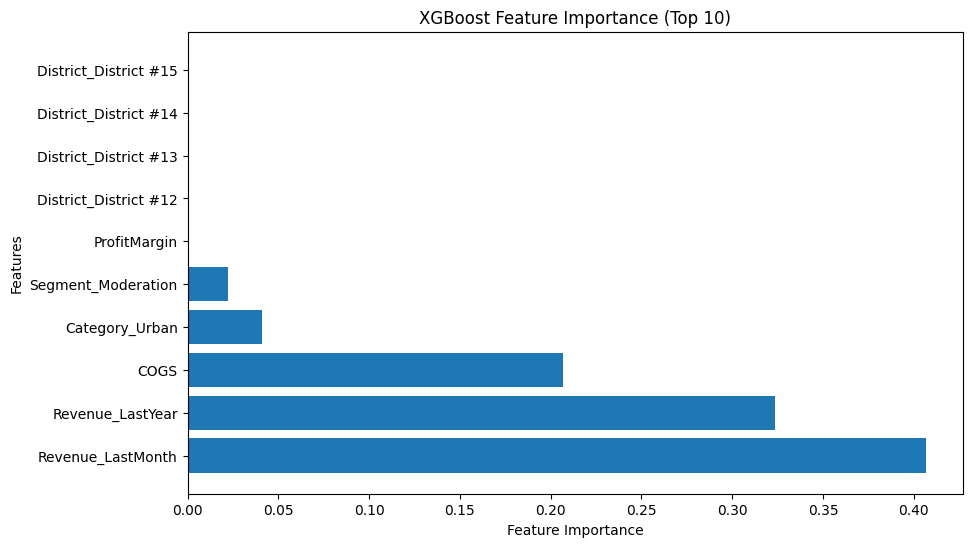

In [142]:
# Plot Feature Importance (Top 10)
importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1][:10]  # Get indices of top 10 features in descending order
feature_names = train_df.drop(columns=["Revenue", "Date"]).columns

plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Top 10)")
plt.show()

# C. 2023 Revenue forecast

In [143]:
# Prepare 2023 data for prediction
future_df = main_df[main_df['Year'] == 2022].copy()
future_df['Year'] = 2023
future_df['Month'] = future_df['Month'] + 1
future_df.loc[future_df['Month'] > 12, 'Month'] = 1
future_df.drop(columns=["Revenue", "Date"], inplace=True)


In [144]:
# Scale 2023 data
X_future = scaler.transform(future_df)

In [145]:
# Predict revenue for 2023
future_df['Predicted_Revenue'] = xgb_model.predict(X_future)

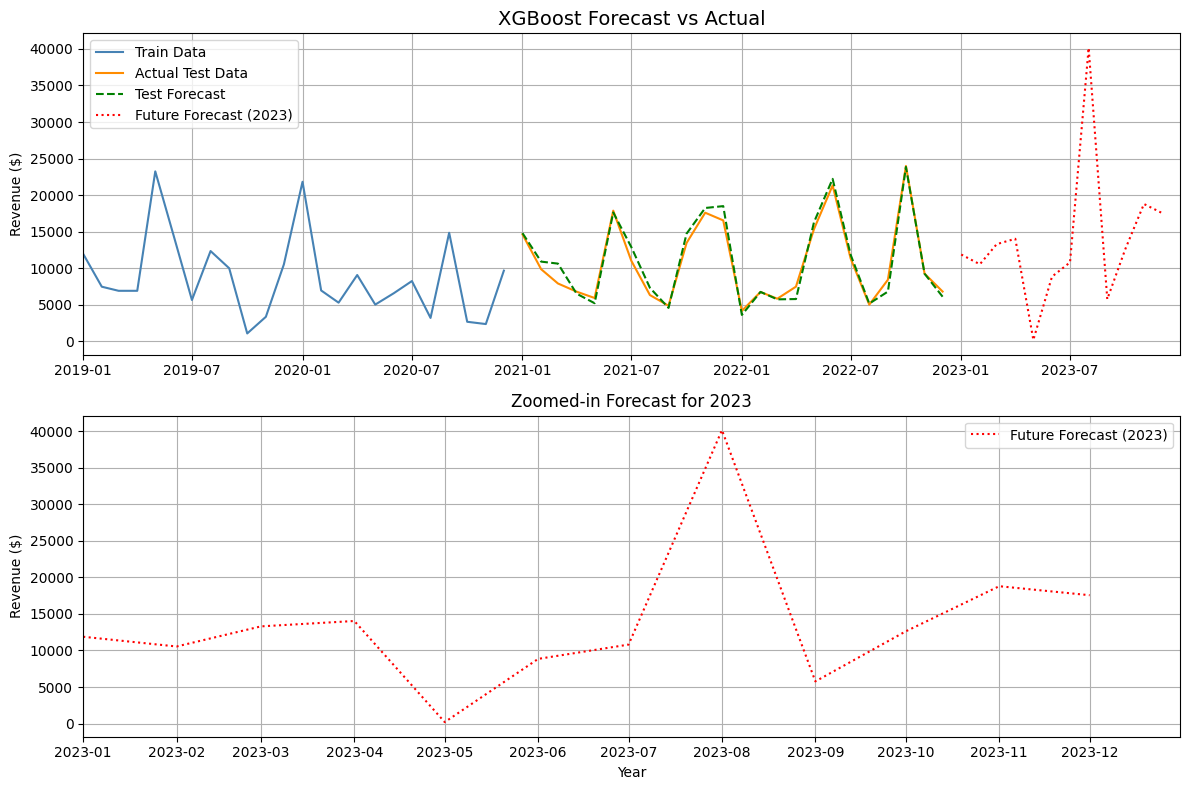

In [103]:
# Seed for reproducibility
np.random.seed(42)

# Training data (main_df equivalent)
dates_train = pd.date_range(start="2019-01-01", end="2020-12-31", freq="MS")
actual_train = np.random.gamma(shape=2, scale=5000, size=len(dates_train))
main_df = pd.DataFrame({"Date": dates_train, "Revenue": actual_train})

# Test data (test_df equivalent)
dates_test = pd.date_range(start="2021-01-01", end="2022-12-31", freq="MS")
actual_test = np.random.gamma(shape=2, scale=5200, size=len(dates_test))
forecast_test = actual_test + np.random.normal(loc=500, scale=1500, size=len(dates_test))
test_df = pd.DataFrame({"Date": dates_test, "Revenue": actual_test, "Forecast": forecast_test})

# Future data (future_df equivalent)
dates_future = pd.date_range(start="2023-01-01", periods=12, freq="MS")
forecast_future = np.random.gamma(shape=2, scale=5500, size=12) + np.random.normal(loc=1000, scale=2000, size=12)
future_df = pd.DataFrame({"Date": dates_future, "Forecast": forecast_future})

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=False)

# Full range (2019-2023)
axes[0].plot(main_df["Date"], main_df["Revenue"], label="Train Data", color="steelblue")
axes[0].plot(test_df["Date"], test_df["Revenue"], label="Actual Test Data", color="darkorange")
axes[0].plot(test_df["Date"], test_df["Forecast"], label="Test Forecast", color="green", linestyle="dashed")
axes[0].plot(future_df["Date"], future_df["Forecast"], label="Future Forecast (2023)", linestyle="dotted", color="red")
axes[0].set_title("XGBoost Forecast vs Actual", fontsize=14)
axes[0].legend()
axes[0].set_ylabel("Revenue ($)")
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2023-12-31"))

# 2023 forecast
axes[1].plot(future_df["Date"], future_df["Forecast"], label="Future Forecast (2023)", linestyle="dotted", color="red")
axes[1].set_title("Zoomed-in Forecast for 2023", fontsize=12)
axes[1].legend()
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Revenue ($)")
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-12-31"))

plt.tight_layout()
plt.show()